# Tarea 02:
### Alumno: Cristian Nova Santoya

## Solución:
Al observar las imágenes se nota que al menos las primeras cuatro de ellas tienen ruido sinusoidal diagonal, y se podría considerar que la reja de la última imagen está compuesta por una especie de suma de funciones sinusoidales, por esto la mejor forma de deshacerse de ese ruido es aplicando un filtro de Notch gausiano. Este filtro de Notch estará formado por la superposición de gausianas en los espacios en que los valores de la Transformada de Fouirier 2D sean sobresalientes.

El lo general las imágenes están formadas por ondas de bajas frecuencias por lo que para no tomarlas en cuenta al momento de determinar que frecuencias apaciguaremos usando Notch se aplicara un filtro pasa bajos a la transformada de Fouirier de cada imagen.

Para comenzar se importaran las librerías necesarias y se crearan cuatro funciones, la primera sera para aplicar un filtro cualquiera a la transformada de una imagen, la segunda sera para superponer funciones gaussianas y así formar el filtro Notch, la tercera para apaciguar las bajas frecuencias de la transformada para así no tomarlos en cuenta dentro del filtro de Notch, y la ultima sera para mostrar las imágenes en blanco y negro mediante plot.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from numpy.fft import fft2, fftshift, ifft2

def implementar_filtro(F_img, filtro):
    "Esta función aplica en filtro proporcionado mediante"
    "multiplicación y lo retorna transformado como una imagen"
    
    F_filtro = fftshift(filtro)  
    new_F_img = F_img*F_filtro
    new_img = abs(ifft2(new_F_img))
    return new_img 

def filtro_gauss(pos_x, pos_y, sigma, filtro):
    "Esta función recibe la posición del filtro a"
    "colocar junto con un sigma que determina la"
    "magnitud de amortiguación de la onda en función"
    "del radio y lo superpone al filtro recibido"
    "(para acelerar el proceso la gaussiana es"
    "colocada dentro de un cuadrante 20X20 pixeles)"
    xi = max([pos_x-10,0])
    xf = min([pos_x+10,len(filtro[0])])
    yi = max([pos_y-10,0])
    yf = min([pos_y+10,len(filtro)])
    
    for columna in range(xi, xf):
        for fila in range(yi, yf):
            delta_x = (columna - pos_x)**2
            delta_y = (fila - pos_y)**2
            valor_gauss = np.exp(-((delta_x + delta_y)/(2*sigma**2)))
            if filtro[fila][columna] < valor_gauss:
                filtro[fila][columna] = valor_gauss
    return filtro

def suabizar_bajos(radio, sigma, img):
    "Esta función retorna un filtro gaussiano pasa altos"
    "dentro de un cuadrante determinado por el valor radio"
    W, H = np.shape(img)
    filtro = np.zeros((W, H))
    for fila in range(W//2 - radio, W//2 + radio):
        for columna in range(H//2 - radio, H//2 + radio):
            delta_x = (columna - W//2)**2
            delta_y = (fila - H//2)**2
            valor_gauss = np.exp(-((delta_x + delta_y)/(2*sigma**2)))
            if filtro[fila][columna] < valor_gauss:
                filtro[fila][columna] = valor_gauss
    filtro = np.ones((W, H))-filtro 
    return filtro

def mostrar_img(img):
    plt.figure()
    plt.imshow(img, cmap ='gray')
    plt.show()

## Función de la tarea2

In [3]:
def filtro_tarea_2(ruta, lim, radio_b, sigma_b, sigma_g):
    "Esta función recibe él limite (lim) desde el cual"
    "se tomaran en cuenta los valores que pasaran a ser"
    "apaciguados por el filtro Notch, el radio en que el"
    "filtro pasa altos protegerá las frecuencias bajas de"
    "la imagen al aplicarse en la transformada(radio_b)"
    "y su sigma respectivo(sigma_b). El ultimo valor"
    "que recibirá sera el sigma de las gaussianas que"
    "conforme el filtro de Notch"
    img = io.imread(ruta)
    mostrar_img(img)
    
    "de la imagen se crea la transformada de esta y su versión Shift"
    F_img = fft2(img)
    F_img_shift = fftshift(abs(F_img))
    W, H = np.shape(img)
    "se crea una matriz vacía de las mismas proporciones de la imagen"
    "y se pone la función shift de la transformada en escala de 0 a 1"
    "(esto se logra dividiéndolo por su máximo)"

    F_frec, F_norm = np.zeros((W, H)), F_img_shift/np.max(F_img_shift)
    "para evitar que las bajas frecuencias sean tomadas en cuenta"
    "se pasa un filtro pasa altos por la transformada escalada"
    pasa_altos = suabizar_bajos(radio_b, sigma_b, F_norm)
    F_norm = F_norm*pasa_altos
    
    "se revisa la transformada y se crea una copia compuesta"
    "por valores entre ceros y unos, habrá unos en donde el"
    "valor del pixel sea mayor al límite"
    for fila in range(len(F_norm)):
        for columna in range(len(F_norm[fila])):
            if F_norm[fila][columna] > lim:
                F_frec[fila][columna] = 1
    "con el propósito de observar mejor la transformada de la imagen"
    "se muestran la el plot"
    mostrar_img(F_frec[W//2-200: W//2+200,H//2-200: H//2+200])
    
    "ahora se superponen las gaussianas en las posiciones marcadas"
    "por F_frec"
    pos_y, pos_x = np.where(F_frec == 1)
    filtro = np.zeros((W, H))
    for n in range(len(pos_x)):
        filtro = filtro_gauss(pos_x[n], pos_y[n], sigma_g, filtro)
    
    "se obtiene el filtro Notch y se aplica a la trasformada"
    "original de la imagen, luego se guarda y se muestra"

    filtro = np.ones((W, H))- filtro
    mostrar_img(filtro)
    new_img = implementar_filtro(F_img, filtro)
    #io.imsave(f"new_{ruta}", new_img)
    mostrar_img(new_img)

Variando los valores lim, radio_b, sigma_b y sigma_g para las diversas imágenes es posible obtener buenos resultados en poco tiempo, salvo por el caso la quinta imagen, la cual requiere que el filtro este compuesto por muchos filtros gausianos para apaciguar el ruido de la reja.

Para la experimentación se utilizo la funíon interact  de la librería ipywidgets, esta función opera como una ventana grafica y permite variar la ruta de la imagen junto con los valores de sus variables para la función filtro_tarea_2.

## simulación

In [4]:
from ipywidgets import interact 
def probar_fun(ruta = "J2.png", lim = 0.0009, radio_b = 200, sigma_b = 50, sigma_g = 1):
    filtro_tarea_2(ruta, lim, radio_b, sigma_b, sigma_g)

interact(probar_fun,
         ruta = ["J1.png", "J2.png", "J3.png", "J4.png", "J5.png"],
         lim = (0,0.05,0.001),
         radio_b = (5,400, 5),
         sigma_b = (1,3000, 10),
         sigma_g = (1,15, 1))
None

interactive(children=(Dropdown(description='ruta', index=1, options=('J1.png', 'J2.png', 'J3.png', 'J4.png', '…

Tras probar la simulación para cada imagen se llego a que los parámetros ideales para cada imagen eran los siguientes.

In [ ]:
Data = {"J1.png":(0.0015, 100, 40, 3),
        "J2.png":(0.0009,200, 50,  1),
        "J3.png":(0.002, 200, 65,  4),
        "J4.png":(0.004, 100,30,1),
        "J5.png":(0.0000003, 400, 3000, 1)}

# Resultaddos:

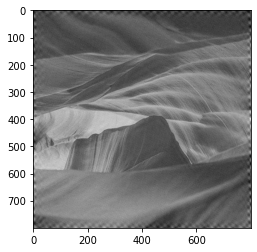

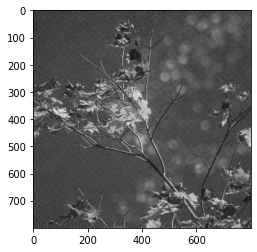

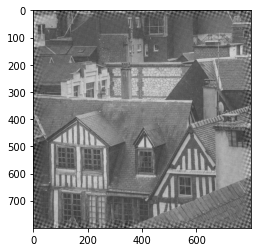

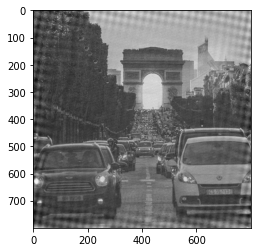

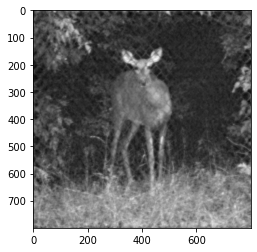

In [8]:
for n in range(1,6):
    img = io.imread(f"new_J{n}.png")
    mostrar_img(img)

fuente:
* https://pythoneyes.wordpress.com/2017/06/19/filtro-de-gauss-con-python-3/
* https://www.analyticslane.com/2018/09/17/creacion-de-graficos-interactivos-en-jupyter-notebook-con-python/